# Configs

In [3]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [4]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LstmModel(nn.Module):
    def __init__(self, timeSerieSize, staticSize):
        super(LstmModel, self).__init__()

        self.timeSerieSize = timeSerieSize
        self.staticSize = staticSize

        # time series
        self.lstm = nn.LSTM(input_size=timeSerieSize, hidden_size=32, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        # static
        self.fc1 = nn.Linear(staticSize, 16)
        self.fc2 = nn.Linear(16, 32)
        # combined
        self.fc3 = nn.Linear(64, 1)

    def forward(self, xTimeSerie, xStatic):
        # time series
        xTimeSerie, _ = self.lstm(xTimeSerie)
        xTimeSerie = self.pool(xTimeSerie.permute(0, 2, 1)).squeeze(2)
        # static
        xStatic = F.leaky_relu(self.fc1(xStatic))
        xStatic = F.dropout(xStatic, p=0.5)
        xStatic = F.leaky_relu(self.fc2(xStatic))
        # combined
        x = torch.cat((xTimeSerie, xStatic), dim=1)
        x = self.fc3(x)
        return x

### Train and eval

In [6]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.dl_train_test import infer, train
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npTrainX).float(),
                torch.from_numpy(staticTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npValX).float(),
                torch.from_numpy(staticValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.from_numpy(npTestX).float(),
                torch.from_numpy(staticTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )

        model = LstmModel(npTrainX.shape[2], staticTrainX.shape[1])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=500,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = infer(model, device, testLoader)
        probas.append(predProbas.detach().cpu().numpy())
        torch.save(model.state_dict(), f"result/lstm_split_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

Epoch 1/500 Train Loss: 0.6815 Val Loss: 0.7907
Epoch 2/500 Train Loss: 0.6660 Val Loss: 0.7848
Epoch 3/500 Train Loss: 0.6532 Val Loss: 0.7805
Epoch 4/500 Train Loss: 0.6415 Val Loss: 0.7749
Epoch 5/500 Train Loss: 0.6283 Val Loss: 0.7690
Epoch 6/500 Train Loss: 0.6107 Val Loss: 0.7638
Epoch 7/500 Train Loss: 0.5933 Val Loss: 0.7564
Epoch 8/500 Train Loss: 0.5776 Val Loss: 0.7496
Epoch 9/500 Train Loss: 0.5587 Val Loss: 0.7423
Epoch 10/500 Train Loss: 0.5448 Val Loss: 0.7373
Epoch 11/500 Train Loss: 0.5311 Val Loss: 0.7314
Epoch 12/500 Train Loss: 0.5187 Val Loss: 0.7292
Epoch 13/500 Train Loss: 0.5036 Val Loss: 0.7279
Epoch 14/500 Train Loss: 0.4969 Val Loss: 0.7270
Epoch 15/500 Train Loss: 0.4947 Val Loss: 0.7276
Epoch 16/500 Train Loss: 0.4925 Val Loss: 0.7214
Epoch 17/500 Train Loss: 0.4940 Val Loss: 0.7234
Epoch 18/500 Train Loss: 0.4803 Val Loss: 0.7260
Epoch 19/500 Train Loss: 0.4725 Val Loss: 0.7221
Epoch 20/500 Train Loss: 0.4750 Val Loss: 0.7231
Epoch 21/500 Train Loss: 0.46

In [7]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8007176637400324 +- 0.021063956417939175 [np.float64(0.8046398046398046), np.float64(0.8241758241758241), np.float64(0.7744061036934281), np.float64(0.822091208600659), np.float64(0.7782753775904461)]
Accuracy: 0.7410912698412698 +- 0.010589410441788587 [0.7555555555555555, 0.7377777777777778, 0.7333333333333333, 0.7511111111111111, 0.7276785714285714]
Specificity: 0.8401640108098032 +- 0.011905089243487408 [np.float64(0.8503401360544217), np.float64(0.8299319727891157), np.float64(0.8493150684931506), np.float64(0.8493150684931506), np.float64(0.821917808219178)]
Precision: 0.6509893596201188 +- 0.01898992035514304 [0.6716417910447762, 0.6376811594202898, 0.6507936507936508, 0.6716417910447762, 0.6231884057971014]
Recall: 0.5561830574488802 +- 0.020400815416450932 [0.5769230769230769, 0.5641025641025641, 0.5189873417721519, 0.569620253164557, 0.5512820512820513]
AUC PR: 0.6707805573939916 +- 0.032005753353364176 [np.float64(0.6501301357801046), np.float64(0.7184134568801859), n

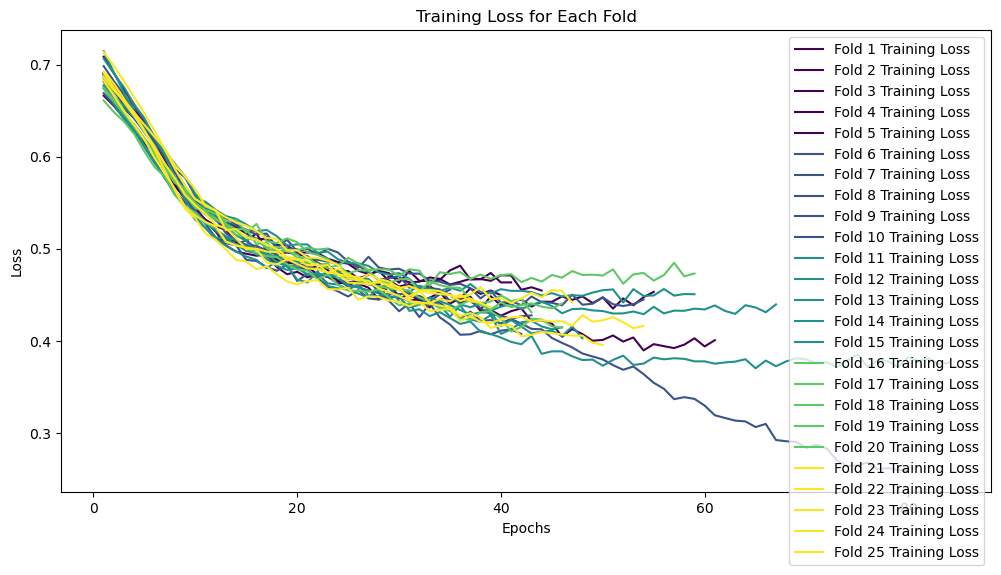

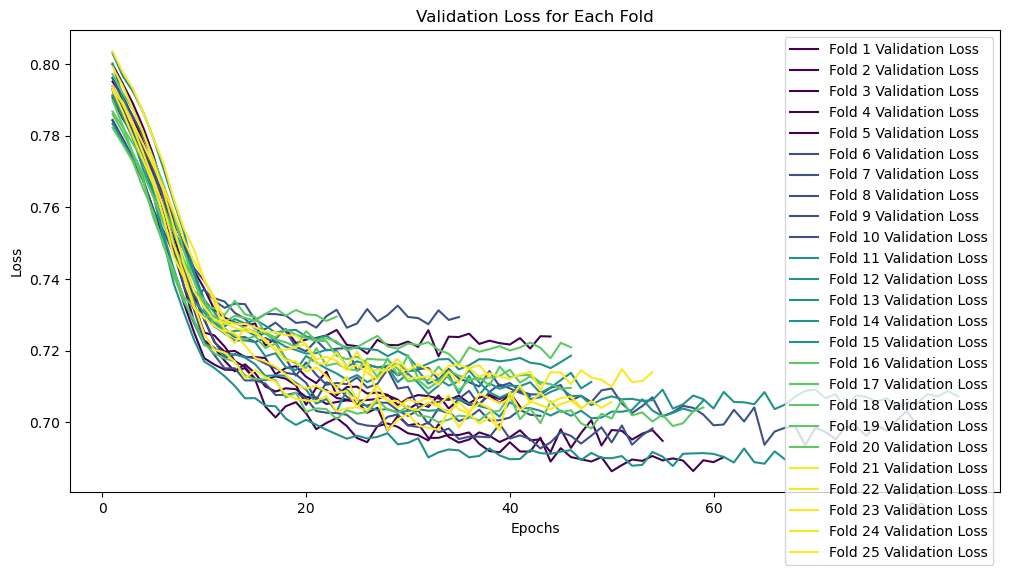

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))

colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_split_val_loss.svg")
plt.show()